data citation:
Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.



# **X Ray Deep Learning ____________________________**

##### Author: Spencer Hadel
***
### Overview

NAOJGAKJGK:LMA:LJHLJ:Ll;

Include stats by profesioanl observations on kaggle etc

include goal numbers to beat etc.


***



***
## Perparation and EDA


In [1]:
#basic imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import glob

#keras for images
import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import preprocessing

#maintain reproducible results for this analysis:
np.random.seed(42)
tf.random.set_seed(42)

The data from kaggle is separated into 3 folders (train, test, and validation). Each of these folders contains two folders, labeled normal and pneumonia. We can easily retrieve the data from each of these folders and subfolders and separate them into three different datasets with two different classes (normal and pneumonia).

__Significance of Train, Test, and Validation Sets__

The Training Set is what our Deep Learning Models will be trained on, with the Validation Set used in that process in order to measure how the models perform at various epochs throughout the training process. Finally, the Test Set will be what we use to measure each model's performance on a new set of data that it has not seen in the training process.


In [2]:
#directories for loading data

train_dir = 'data/kaggle--chest_xray/train'
test_dir = 'data/kaggle--chest_xray/test'
val_dir = 'data/kaggle--chest_xray/val'


# All images will be rescaled by 1./255

#explain size

#explain class_mode

#explain what this code does

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        #binary classification problem:
        class_mode='binary')


#set shuffle to false for val and test data!

val_data = val_datagen.flow_from_directory(
        val_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        shuffle= False,
        #binary classification problem:
        class_mode='binary')

test_data = test_datagen.flow_from_directory(
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        shuffle = False,
        #binary classification problem:
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We successfully created datsets for train, test, and val!

Next let's check what the "2 classes" in this data are:

In [3]:
#identify class labels in data
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

We can see that 'NORMAL' is class 0 and 'PNEUMONIA' is class 1. 

If we were to count the image files in the data folders, we could see that there are 1341 images in the training dataset in the NORMAL subfolder, and 3875 images in the PNEUMONIA subfolder. Our next step is to quickly verify that our data in the notebook matches these results, as well as those in the test and val folders:

In [4]:
from collections import Counter

train_counter = Counter(train_data.classes)    
test_counter = Counter(test_data.classes)    
val_counter = Counter(val_data.classes)    

#train:
print('Train:')
print('NORMAL: ', train_counter[0])
print('PNEUMONIA: ', train_counter[1])
print('')

#test:
print('Test:')
print('NORMAL: ', test_counter[0])
print('PNEUMONIA: ', test_counter[1])
print('')

#val:
print('Validation:')
print('NORMAL: ', val_counter[0])
print('PNEUMONIA: ', val_counter[1])
print('')

Train:
NORMAL:  1341
PNEUMONIA:  3875

Test:
NORMAL:  234
PNEUMONIA:  390

Validation:
NORMAL:  8
PNEUMONIA:  8



These numbers do in fact line up! Let's also get a better understanding of how that data is balanced:

In [5]:
#print percentage of NORMAL results in each set
train_norm_percent = train_counter[0]/(train_counter[0]+train_counter[1])
test_norm_percent = test_counter[0]/(test_counter[0]+test_counter[1])
val_norm_percent = val_counter[0]/(val_counter[0]+val_counter[1])

print('Percent NORMAL in train: {0:.0%}'.format(train_norm_percent))
print('Percent NORMAL in test: {0:.0%}'.format(test_norm_percent))
print('Percent NORMAL in val: {0:.0%}'.format(val_norm_percent))

Percent NORMAL in train: 26%
Percent NORMAL in test: 38%
Percent NORMAL in val: 50%


So the data is most imbalanced in the train, less so in test, and not at all imbalanced in val. That being said, the data is never drastically imbalanced, and there are still plenty of each of the two classes in the train dataset to create successful models with.

### Observing the Images

Our next step is to analyze what this image data actually contains!

We'll use the images in the validation folder for examples of NORMAL and PNEUMONIA classes.

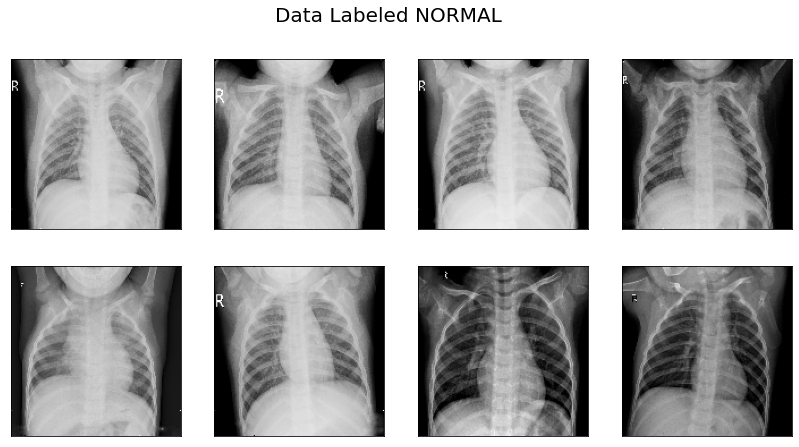

In [6]:
#collect only images where label is 0 (NORMAL)
norm_imgs = val_data[0][0][val_data[0][1]==0]
normal_fig,normal_ax = plt.subplots(2,4,figsize=(14,7))

for idx,image in enumerate(norm_imgs[:8]):
        active_axis = normal_ax[idx//4][idx%4]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.suptitle('Data Labeled NORMAL', fontsize=20);

normal_fig.savefig('./img/0-normal_xrays.png')

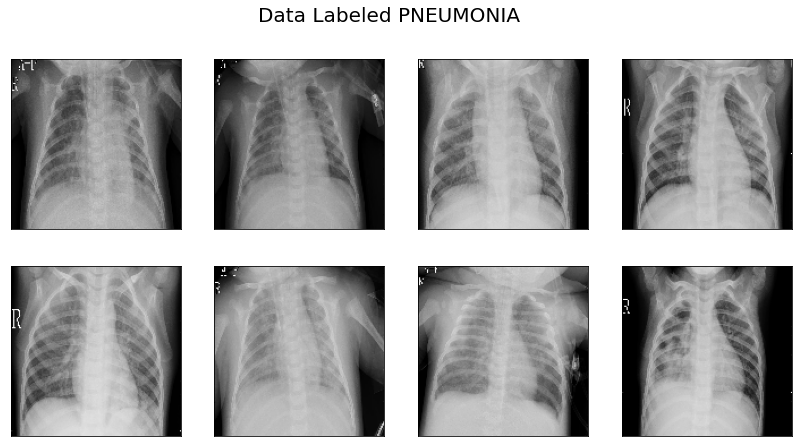

In [7]:
#collect only images where label is 1 (PNEUMONIA)
pneum_imgs = val_data[0][0][val_data[0][1]==1]
pneum_fig,normal_ax = plt.subplots(2,4,figsize=(14,7))

for idx,image in enumerate(pneum_imgs[:8]):
        active_axis = normal_ax[idx//4][idx%4]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
pneum_fig.suptitle('Data Labeled PNEUMONIA', fontsize=20);

pneum_fig.savefig('./img/0-pneum_xrays.png')

__Interpretation of these Images__

It's clear that to an untrained medical eye, the two groups contain very similar images. A few of the X-Rays in the pneumonia set may be identifiably different than those in the normal set, but it would by no means be easy to instinctively differentiate betweenn the two sets if a random image was flashed on the screen. 

This is why we will attempt to create a Neural Network that will identify the differences in ways out human eyes and brains cannot.

## Modeling the Data

In [8]:
#import necessary modeling and evaluating modules
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#### Metrics

When we look at the models in this section, we will be focused on a few different scoring metrics in various instances. 

> * Recall (a.k.a. Sensitivity): __Recall is crucial__ in this analysis, particularly when evaluating our model against the test data. This metric will show us our model's ability to __avoid False Negatives__, or in other words to __prevent misdiagnosing someone as healthy when in reality they are ill__. 
> * Binary Accuracy: Accuracy is of course, important. It will tell us how well our model successfully predicts cases of pneumonia. Ideally, we will always want our accuracy score to go up. Without an accurate model, there is no valuable outcome for this analysis. Binary accuracy is a built in keras metric used specifically for binary classification problems like this one.
> * Precision: Our third significant metric explains how many of the Predicted Positives of our model are correct. This is important to avoid misdiagnosing a patient as ill, but is also less crucial than the other metrics as the primary goal is to help people in need.

In [9]:
my_metrics = [metrics.BinaryAccuracy(),
              metrics.Precision(),
                metrics.Recall()]

In [10]:
#create dataframe for storing scores

df_model_scores = pd.DataFrame(columns = ['Model Name', 'Accuracy', 'Loss', 'Precision', 'Recall'])
# print(df_model_scores)

***
### Baseline Convolutional Model

#### Designing the Model

The general construction of our baseline model will be as follows:

__Loss__ - For this analysis, since we are creating a binary classification model, we will be using Binary Cross-Entropy as our loss function.

__Optimizer__ - We will also begin our analysis with one of the standard optimizers for binary classification, Stochastic Gradient Descent (SGD).

__Sequential Model:__ Since we are creating a binary classification model that only needs one layer for inputs and one layer for outputs, we  will create a Sequential Model.

__ReLu Activation:__ We will be using the Rectified Linear Unit (ReLu) activation function on our layers. This is standard and used for high performance computation.

__Convolutional Layers(2D):__ Since we are identfying features of images, we will use 2D Convolutional Layers to detect significant features of each image to train our models.

__Max Pooling Layer(2D):__ The Max Pooling Layer downsamples the layer before it, in order to create a summary of the convolutional patterns before it. This improves execution time during the training of our model.

__Flatten:__ We apply a Flattening layer to convert our multidimensional arrays into one continuous vector.

__Dense:__ Standard neural network layer, which receives input to every neuron in the layer from every neuron int the previous layer (hence the name "Dense").

__Sigmoid Output:__ The model ends with a Sigmoid output layer, which transforms the calculations of the previous layers into a probability of the outcome being one of the two binary classes. This is standard for our binary classification setup.

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

#sigmoid output
model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    #stochastic gradient descent optimizer:
    optimizer='sgd',
    
    #binar crossentropy loss:
    loss='binary_crossentropy',
    
    #metrics
    metrics=[my_metrics]
    )

#summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

#### Training

In [12]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data
    validation_data=val_data,
    batch_size = 32
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 110s 670ms/step - loss: 0.5313 - binary_accuracy: 0.7517 - precision: 0.7588 - recall: 0.9760 - val_loss: 0.7777 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 105s 643ms/step - loss: 0.3524 - binary_accuracy: 0.8533 - precision: 0.8722 - recall: 0.9404 - val_loss: 0.9103 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 110s 676ms/step - loss: 0.2457 - binary_accuracy: 0.8999 - precision: 0.9230 - recall: 0.9440 - val_loss: 1.9937 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 108s 659ms/step - loss: 0.1850 - binary_accuracy: 0.9298 - precision: 0.9461 - recall: 0.9603 - val_loss: 0.8295 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

Now that the model has finished fitting to the data , we can start by visualizing its accuracy and loss throughout each epoch:

##### Evaluating Accuracy and Loss across Epochs

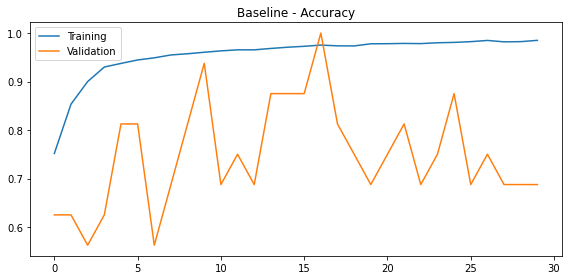

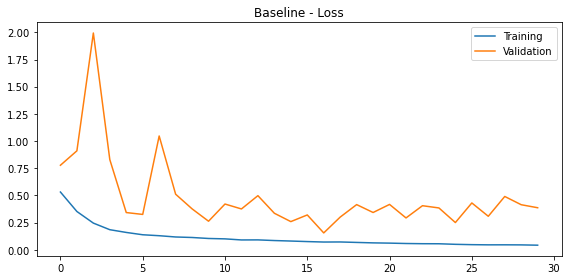

In [13]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True

fig1 = plt.figure()
plt.title('Baseline - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()


fig2 = plt.figure()
plt.title('Baseline - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that our baseline model actually did decently well when comparing Training and Validation loss. In other words, the model had very similar loss results between the training and validation sets. The same cannot be said for the accuracy, which fluctuated and consistendtly remained problematically low for the validation data.

##### Evaluating on Test Data

Now we will check the model's ability to make predictions on the test dataset. We will display these predictions in the form of a confusion matrix showing the predictions and true labels for each item in the data.

In [14]:
# create confusion matrix helper function:
def plot_confusion(title, save_name):
    #round to get binary assignment from prediction
    preds = np.round(model.predict(test_data),0)
    test_labels = test_data.labels

    #confusion matrix for test data
    conf_matrix = confusion_matrix(test_labels,preds)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    plt.savefig('./img/'+save_name+'.png')
    plt.show()

20/20 [==============================] - 9s 426ms/step


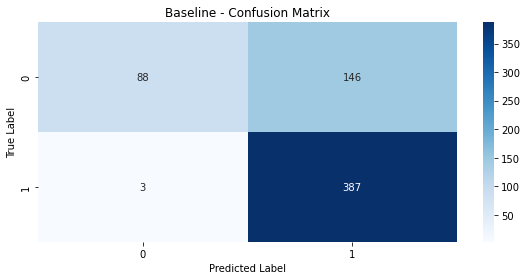

In [15]:
plot_confusion('Baseline - Confusion Matrix', '1-baseline-conf')

The above confusion matrix shows the 4 different types of predictions a model can make. As a refresher:

__True Positives (Bottom Right)__ indicate the that model accurately predicting Pneumonia in an X-Ray.

__True Negatives (Top Left)__ indicate that the model accurately predicted that the X-Ray was of a healthy subject.

__False Positives (Top Right)__ indicate that the model innacurately assessed the X-Ray as indicating Pneumonia, when in fact the patient was healthy.

__False Negatives (Bottom Left)__ similarly show a prediction that the X-Ray was that of a healthy patient, when the correct assessment would be Pneumonia.

The most important number we want to focus on is the one in the __False Negatives__ box. Ideally, this number will be as close to 0 as possible in order to avoid ever misdiagnosing a patient as healthy, thus putting them at significant risk!

This model shows a very ideal number of False Negatives (only 3!), giving us the high __recall__ score we hoped for! So at the very least, we know that our baseline model would at least only very rarely identify a patient as healthy when they were in fact sick. __Hoewever__, this model also has a very poor __precision__ score, as it predicted 146 times that a patient had pneumonia when in fact they were healthy. In future models, we want to bring this number down, in turn bringing up the __accuracy__ score, si that our model can accurately predict the correct labels for the test set.

In [16]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 8s 354ms/step - loss: 1.2459 - binary_accuracy: 0.7612 - precision: 0.7261 - recall: 0.9923


In [17]:
model_name = 'Baseline CNN'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.761218,1.245863,0.726079,0.992308


Our first batch of model scores on the test data are stored above. This will help later as we add more models so that we can compare the results of each.

In [18]:
#save info for later retrieval:

#model and history
model.save('./models/1-baseline')
model_1 = model
history_1 = history

#acc and loss charts
fig1.savefig('./img/1-base-acc.png')
fig2.savefig('./img/1-base-loss.png')

INFO:tensorflow:Assets written to: ./models/1-baseline\assets


INFO:tensorflow:Assets written to: ./models/1-baseline\assets


***
### Model 2 - Increase Batch Size

#### Designing the Model

The first model didn't perform terribly, but we want to look into solutions for __increasing the accuracy__ of our neural network while also __reducing the loss__, and hopefully __maintaining the high recall score__. Next we will attempt to run a nearly identical model, but with an increased batch size in the training phase. In the training section, this will look like:
    
    batch_size = 64
    
Because of the variance in our data mentioned earlier, we will increase the batch size (which is 32 by default) to make sure that our model is not being poorly trained due to not getting an appropriate amount of data per batch.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
# model.summary()

#### Training

In [20]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data to prevent overfitting to training data
    validation_data=val_data,
    batch_size = 64
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 101s 614ms/step - loss: 0.5265 - binary_accuracy: 0.7568 - precision: 0.7590 - recall: 0.9775 - val_loss: 0.7210 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 99s 609ms/step - loss: 0.3792 - binary_accuracy: 0.8357 - precision: 0.8554 - recall: 0.9373 - val_loss: 0.7546 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 100s 610ms/step - loss: 0.2520 - binary_accuracy: 0.8936 - precision: 0.9131 - recall: 0.9468 - val_loss: 0.4289 - val_binary_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 4/30
163/163 [==============================] - 100s 612ms/step - loss: 0.1894 - binary_accuracy: 0.9270 - precision: 0.9423 - recall: 0.9605 - val_loss: 0.6374 - val_binary_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 5/30
163/163 [=============

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

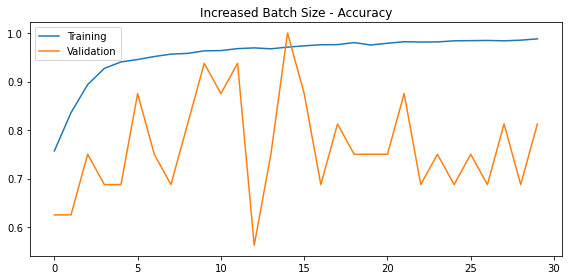

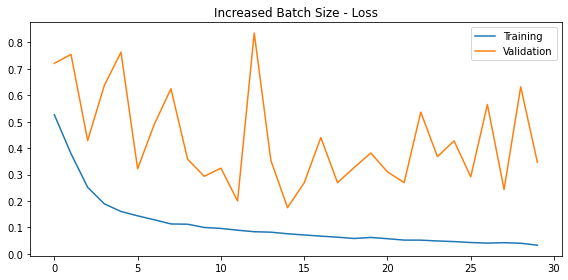

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Increased Batch Size - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()


fig2 = plt.figure()
plt.title('Increased Batch Size - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

These visualizations unfortunately show us that the models performance on validation data only became more erratic.


##### Evaluating on Test Data

20/20 [==============================] - 9s 410ms/step


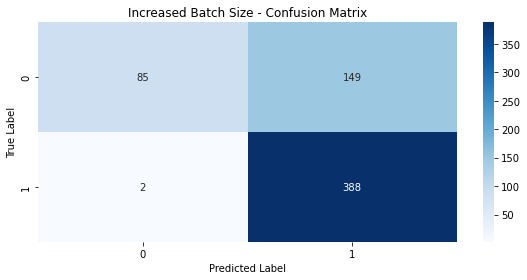

In [22]:
plot_confusion('Increased Batch Size - Confusion Matrix', '2-batch-conf')

This confusion matrix is essentially the same as the previous, but actually predicts incorrectly slightly more than before.

In [23]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 9s 399ms/step - loss: 1.3042 - binary_accuracy: 0.7580 - precision: 0.7225 - recall: 0.9949


In [24]:
model_name = 'Increased Batch Size'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.761218,1.245863,0.726079,0.992308
1,Increased Batch Size,0.758013,1.304202,0.722533,0.994872


We can see from the dataframe storing the scores that the Increased Batch Size model was in fact not what we were looking for. Every score went down slightly, with the exception of Recall, which increased very negligibly. This is fine, we just know now that the model does not requure a larger batch size to increase performance.

In [25]:
#save info for later retrieval:

#model and history
model.save('./models/2-increased-batch')
model_2 = model
history_2 = history

#acc and loss charts
fig1.savefig('./img/2-batch-acc.png')
fig2.savefig('./img/2-batch-loss.png')

INFO:tensorflow:Assets written to: ./models/2-increased-batch\assets


INFO:tensorflow:Assets written to: ./models/2-increased-batch\assets


***
### Model 3 - Augment Training Data

Our previous model visualizations showed some fairly erratic performance when it came to the accuracy and loss of the validation data as compared to the training data. This can be a symptom of __overfitting__, where the model is getting trained __too well__ on the training data and cannot detect appropriate patterns when applied to the validation data.

A standard way we cann prevent overfitting on this training data is to augment the training data. Our data is all composed of very, very similar images of x-rays of ribcages, with very few differences in the scale or positioning. We don't have additional x-rays that look different to this, so we will instead make it so that the training images will be randomly repositioned and manipulated (within constraints). This will help our model learn specific patterns from various rotational angles, zoom levels, and positions. This will prevent the model from training itself too precisely.

In [26]:
#augment data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

aug_train_data = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150,150),
                                                    class_mode='binary') 

Found 5216 images belonging to 2 classes.


As an example, lets look at how some of the images from this new data generator might look:

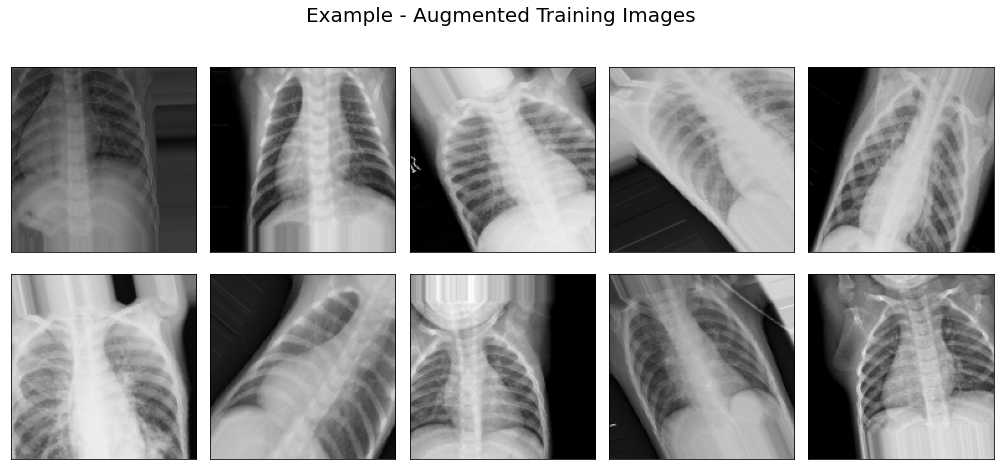

In [27]:
aug_imgs_example = aug_train_data[0][0][0:10]

aug_fig,normal_ax = plt.subplots(2,5,figsize=(14,7))

for idx,image in enumerate(aug_imgs_example):
        active_axis = normal_ax[idx//5][idx%5]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
aug_fig.suptitle('Example - Augmented Training Images', fontsize=20);

aug_fig.savefig('./img/0-augmented_img)example.png')

This makes our training data much more varied, and should hopefully train our model to make more generalized predictions about patterns it detects and prevent overfitting.

#### Designing the Model

The model will be designed the same as 

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))


#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
# model.summary()

#### Training

In [29]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    train_data,
    epochs=30,
     #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 109s 660ms/step - loss: 0.5190 - binary_accuracy: 0.7550 - precision: 0.7593 - recall: 0.9728 - val_loss: 0.9792 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 107s 654ms/step - loss: 0.3506 - binary_accuracy: 0.8505 - precision: 0.8699 - recall: 0.9391 - val_loss: 0.4862 - val_binary_accuracy: 0.6875 - val_precision: 0.6667 - val_recall: 0.7500
Epoch 3/30
163/163 [==============================] - 107s 657ms/step - loss: 0.2373 - binary_accuracy: 0.9043 - precision: 0.9260 - recall: 0.9468 - val_loss: 0.5344 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 102s 623ms/step - loss: 0.1854 - binary_accuracy: 0.9285 - precision: 0.9451 - recall: 0.9595 - val_loss: 0.6837 - val_binary_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

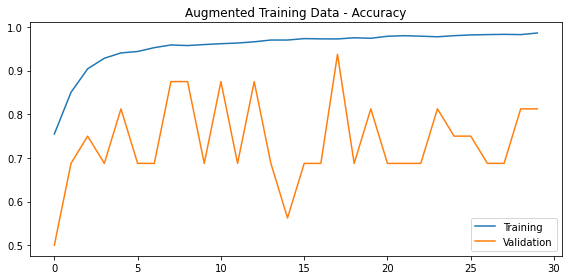

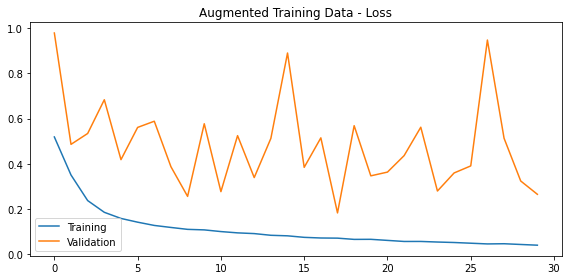

In [30]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True



fig1 = plt.figure()
plt.title('Augmented Training Data - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()



fig2 = plt.figure()
plt.title('Augmented Training Data - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that there is stil not a lot of consistency on the validation data performance.


##### Evaluating on Test Data

20/20 [==============================] - 8s 385ms/step


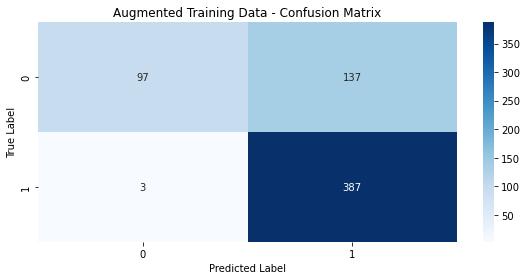

In [31]:
plot_confusion('Augmented Training Data - Confusion Matrix', '3-aug-data-conf')

This confision matrix shows us that at the very least, our model is slightly better at predicting __True Negatives (Top Left)__, without harming it's ability to avoid __False Negatives (Bottom Left)__, which is a step in the right direction.

In [32]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

20/20 [==============================] - 8s 388ms/step - loss: 1.0426 - binary_accuracy: 0.7756 - precision: 0.7385 - recall: 0.9923


In [33]:
model_name = 'Augmented Training Data'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

,Model Name,Accuracy,Loss,Precision,Recall
0,Baseline CNN,0.761218,1.245863,0.726079,0.992308
1,Increased Batch Size,0.758013,1.304202,0.722533,0.994872
2,Augmented Training Data,0.775641,1.042606,0.738550,0.992308


We can see from the dataframe that this attempt produced better scores on the test data than previous models. Every single metric has improved, with the exception of Recall which remains the same high result as in the baseline. We will keep the augmented training data for future models.

In [34]:
#save info for later retrieval:

#model and history
model.save('./models/3-augmented-data')
model_3 = model
history_3 = history

#acc and loss charts
fig1.savefig('./img/3-augmented-data-acc.png')
fig2.savefig('./img/3-augmented-data-loss.png')

INFO:tensorflow:Assets written to: ./models/3-augmented-data\assets


INFO:tensorflow:Assets written to: ./models/3-augmented-data\assets


***
### Model 4 - More Layers

We will now attemot to add more dense layers in an attempt to __increase the accuracy score__ of our model.

#### Designing the Model

In [35]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

#### Training

In [ ]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

Epoch 1/30
163/163 [==============================] - 132s 806ms/step - loss: 0.5924 - binary_accuracy: 0.7363 - precision: 0.7427 - recall: 0.9777 - val_loss: 0.8057 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 131s 801ms/step - loss: 0.5670 - binary_accuracy: 0.7429 - precision: 0.7429 - recall: 1.0000 - val_loss: 0.8861 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 132s 809ms/step - loss: 0.5603 - binary_accuracy: 0.7431 - precision: 0.7433 - recall: 0.9992 - val_loss: 0.8317 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 133s 816ms/step - loss: 0.5482 - binary_accuracy: 0.7452 - precision: 0.7459 - recall: 0.9964 - val_loss: 0.6975 - val_binary_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 5/30
163/163 [============

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('More Layers - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('More Layers - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('More Layers - Confusion Matrix', '4-more-layers-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'More Layers'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/4-more-layers')
model_4 = model
history_4 = history

#acc and loss charts
fig1.savefig('./img/4-more-layers.png')
fig2.savefig('./img/4-more-layers.png')

### Model 5 - New Optimizer - RMSprop

RMSprop(lr=2e-5)

##### ___________________________________________________________________________

#### Designing the Model

##### ___________________________________________________________________________

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
# model.summary()

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [ ]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('RMSprop - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('RMSprop - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('RMSprop - Confusion Matrix', '5-rmsprop-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'RMSprop Optimizer'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/5-rmsprop')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/5-rmsprop-acc.png')
fig2.savefig('./img/5-rmsprop-loss.png')

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('RMSprop - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('RMSprop - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('RMSprop - Confusion Matrix', '5-rmsprop-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'RMSprop Optimizer'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/5-rmsprop')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/5-rmsprop-acc.png')
fig2.savefig('./img/5-rmsprop-loss.png')

### Model 6 - New Optimizer - Adam

##### ___________________________________________________________________________

#### Designing the Model

##### ___________________________________________________________________________

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
# model.summary()

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [ ]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
    
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Adam - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('Adam - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('Adam - Confusion Matrix', '6-adam-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'Adam Optimizer'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/6-adam')
model_6 = model
history_6 = history

#acc and loss charts
fig1.savefig('./img/6-adam-acc.png')
fig2.savefig('./img/6-adam-loss.png')

### Model 7 - Implement Regularization

Using Dropout to 

"
Dropout Regularization is a technique for reducing overfitting and improve generalization (the ability for the model to make valuable predictions on a new set of data). Specifically, the dropout technique allows the model to emulate a very large model because it randomly discards nodes. The model will still have the number of layers originally created, but the nodes will randomly be thrown out. This method is useful for reducing compute intensity and incorporates an element of randomness that's effective for reducing overfitting.
"

#### Designing the Model

##### ___________________________________________________________________________

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#DROPOUT REGULARIZATION:
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#compile
model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[my_metrics]
    )

#display summary
model.summary()

##### ___________________________________________________________________________
(same model, new optimizer in compile)

#### Training

In [ ]:
#track time model takes
start = datetime.datetime.now()

history = model.fit(
    aug_train_data,
    epochs=30,
    #fit to validation data to prevent overfitting to training data
    validation_data=val_data
    
)

#display time taken
end = datetime.datetime.now()
print('Training Time: ',end-start)

#### Evaluating

##### Evaluating Accuracy and Loss across Epochs

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range((len(acc)))

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True


fig1 = plt.figure()
plt.title('Dropout Regularization - Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()

fig2 = plt.figure()
plt.title('Dropout Regularization - Loss')
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.show()

We can see from the visualizations that

##### _____________________________________________

Now we will check this model's confusion matrix

In [ ]:
plot_confusion('Dropout - Confusion Matrix', '7-dropout-conf')

This confision matrix shows us that

##### _______________________________________________

In [ ]:
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_data)
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)

In [ ]:
model_name = 'Dropout Regularization'

df_model_scores = df_model_scores.append({'Model Name' : model_name, 'Accuracy' : test_acc, 'Loss' : test_loss, 'Precision' : test_prec, 'Recall' : test_rec},
        ignore_index = True)

df_model_scores

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/7-dropout')
model_7 = model
history_7 = history

#acc and loss charts
fig1.savefig('./img/7-dropout-acc.png')
fig2.savefig('./img/7-dropout-loss.png')

We can see from the dataframe storing the scores that 

###### _____________________________________________

In [ ]:
#save info for later retrieval:

#model and history
model.save('./models/8-tuned-vgg-19')
model_5 = model
history_5 = history

#acc and loss charts
fig1.savefig('./img/9-tuned-vgg-19-acc.png')
fig2.savefig('./img/9-tuned-vgg-19-loss.png')

In [ ]:
#visualize activations of best model


visualize activations at end!


#plot model??

# utils.plot_model(model=nt_model,to_file='images/nt_model.png',show_shapes=True,dpi=64)

***
***
***
***

# Conclusions